This kernel is from https://www.kaggle.com/wvadim/keras-tf-lb-0-18

## Introduction
This is actually my first public kernel, so i hope it will be useful for someone.

Before you read the notebook, it is immportant to know that this notebook is a compilation of already existing notebooks and some model modifications
Here is list of notebooks:
* Data analysis - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
* Some ideas - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl

Before running the model it is good idea to run thgrough kernels mentioned here and upvote them.

### Comments
I've executed this code on my machine with 1080 TI and it may be pretty slow if you have low-end GPU or CPU

It is also important that i don't know how to execute code in the notebook with GPU, since keras is not freeing memory after model training, so train results here may be uncomplete.

I am also not sure about random seed initialization and haven't checked it, so maybe your results may differ from mine.

I am also sorry for a WinAPI style functions with 10+ arguments, but this solutin was made less than in a one day and basically my second solution. If someone is able to rewrite it in a normal style i will appreciate that, so feel free to fork and rewrite.

In [1]:
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.random.set_seed(683)
# Uncomment this to hide TF warnings about allocation

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, 
                                 denoise_bilateral, 
                                 denoise_wavelet, 
                                 estimate_sigma, 
                                 denoise_tv_bregman, 
                                 denoise_nl_means)

from skimage.filters import gaussian
from skimage.color import rgb2gray

# Data reading and visulatization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


### Model, Dense Example

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
output_1 = Dense(64, activation='relu')(inputs)
output_2 = Dense(64, activation='relu')(output_1)
predictions = Dense(10, activation='softmax')(output_2)

In [3]:
input

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x000001D3EC995CC0>>

In [4]:
output_1

<tf.Tensor 'dense_1/Relu:0' shape=(None, 64) dtype=float32>

In [5]:
Dense(64, activation='relu')

In [6]:
output_2

<tf.Tensor 'dense_2/Relu:0' shape=(None, 64) dtype=float32>

In [7]:
predictions

<tf.Tensor 'dense_3/Softmax:0' shape=(None, 10) dtype=float32>

First of all, some data preprocessing is required.

The basic idea is that images, that provided in a dataset are very noisy and if we will get rid of granular noise, we will be able to predict better and construct noisy dataset by our own.

It is also interesting to train a denoising autoencoder on dataset in order to extract some global features that may be used further on model training.

In [8]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2
        
        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))
        
        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

In [9]:
def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [10]:
train = pd.read_json('data/train.json')
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

In [11]:
# These are train flags that required to train model more efficiently and 
# select proper model parameters

train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
loab_b = False or load_all
load_img = False or load_all

In [12]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                  weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
        
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
        print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    # images = tf_reshape(images)
    
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame['is_iceberg'])
    else:
        y = None
    return y, band, images

In [13]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping


Plotting some random images to check how cleaning works



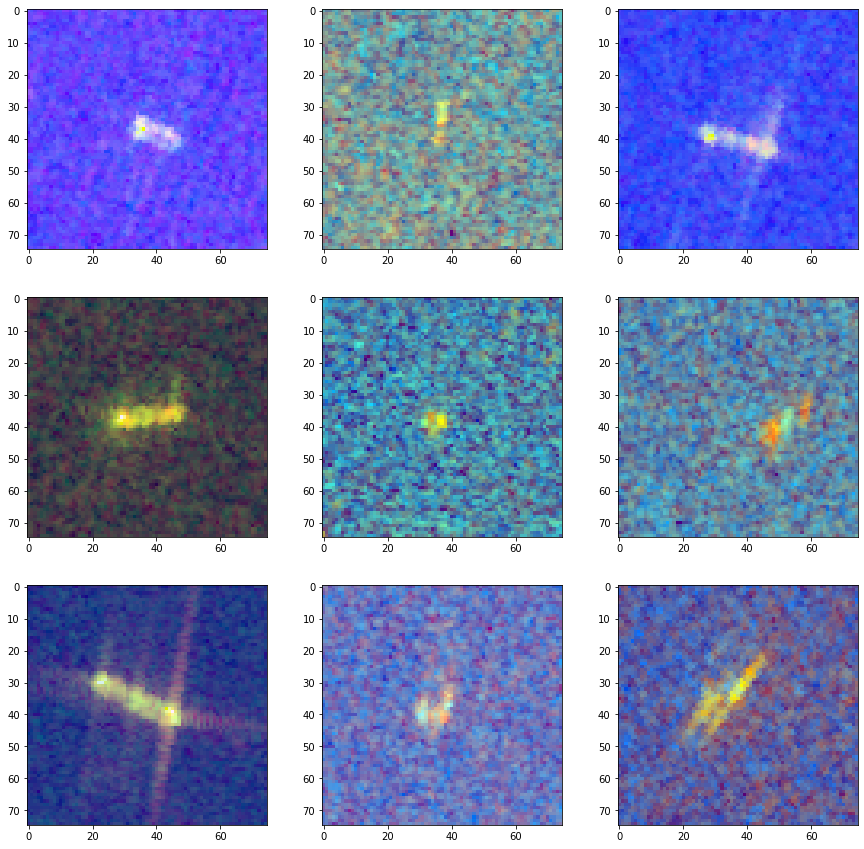

In [14]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

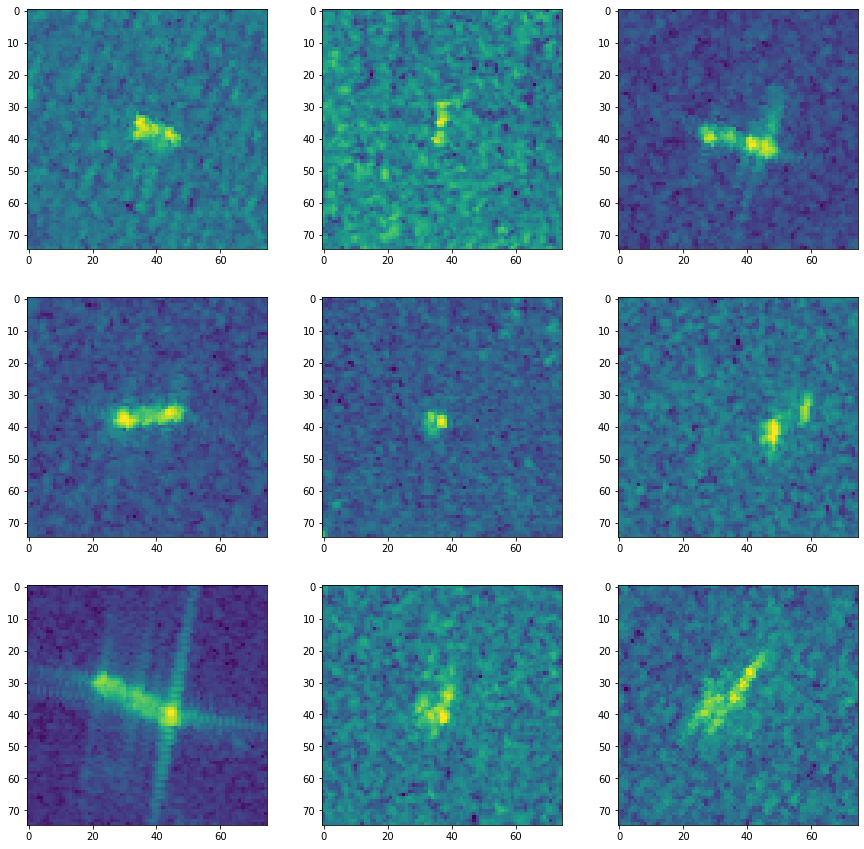

In [15]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

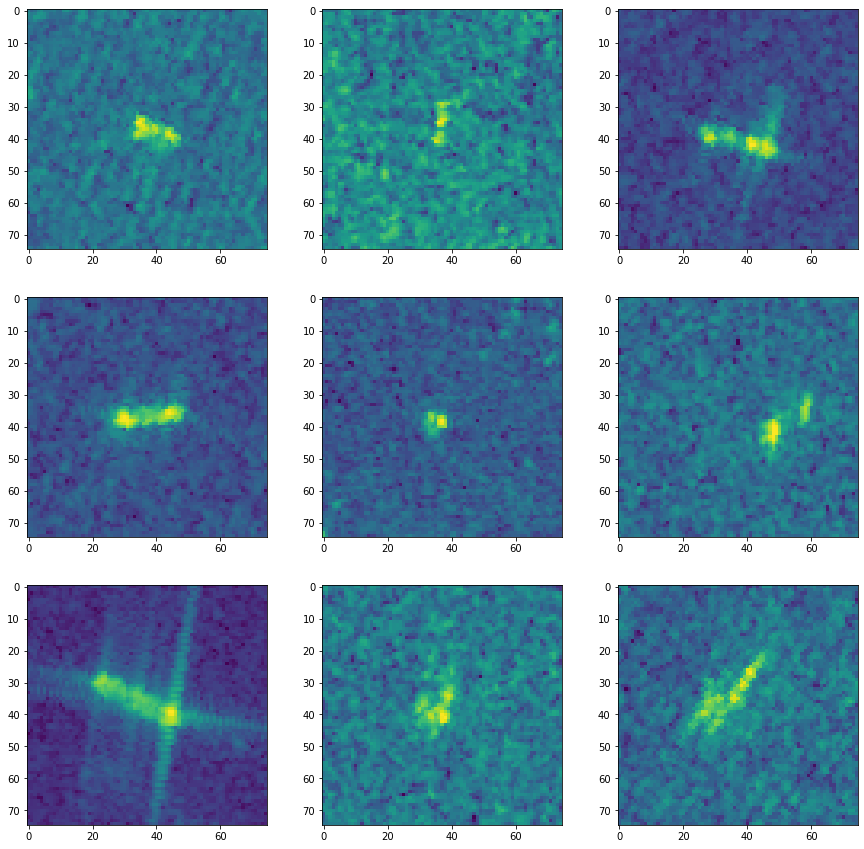

In [16]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

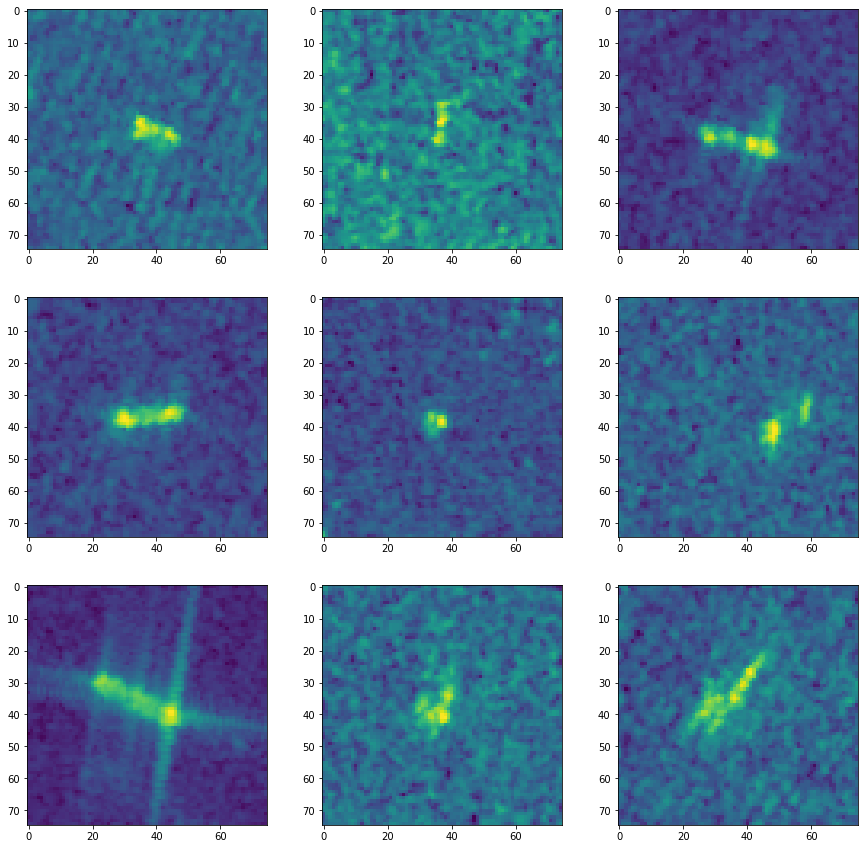

In [17]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

## A few words about model

The model itself consists of 3 convolutional neural networks. Two basic networks and one combined. The idea is to train two basic networks on different data representations and after that, using trained convolutional layers in combination to train common network.

Architecture for these networks is taken from notebook mentioned in the beginning.

For training i'm using 3 datasets, 1 that network sees only once and default keras val split for model selection.

In [18]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model

In [19]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [20]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    
    # An Iterator yielding tuples of (x, y) where x is a numpy array 
    # of image data (in the case of a single image input) or a list of 
    # numpy arrays (in the case with additional inputs) 
    # and y is a numpy array of corresponding labels. 
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [21]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(checkpoint_name)
    return model

In [22]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [23]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=30,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights('common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

Model parameters that are used in training assumes that you have enough computational power to process all the data.

(Don't know if it is obvious or not) The important moment here is to save 3 sets, since if you are selecting model based on a validation set it affects final performance since it causes indirect observations of validation set and affect final evaluation score.

In [24]:
# Best parameters I got are
# epochs: 250, lr: 8e-5, batch_size: 32
common_model = train_models((y_train, X_b, X_images), 7e-4, 32, 50, 1, return_model=True)

Training bandwidth network
Epoch 1/50
39/38 [==============================] - 14s 364ms/step - loss: 0.6768 - accuracy: 0.5718 - val_loss: 2.9779 - val_accuracy: 0.5253
Epoch 2/50
39/38 [==============================] - 9s 239ms/step - loss: 0.6027 - accuracy: 0.6582 - val_loss: 2.3346 - val_accuracy: 0.5253
Epoch 3/50
39/38 [==============================] - 9s 236ms/step - loss: 0.5806 - accuracy: 0.6819 - val_loss: 1.1021 - val_accuracy: 0.5207
Epoch 4/50
39/38 [==============================] - 9s 238ms/step - loss: 0.5519 - accuracy: 0.6974 - val_loss: 0.6152 - val_accuracy: 0.6406
Epoch 5/50
39/38 [==============================] - 9s 235ms/step - loss: 0.4999 - accuracy: 0.7545 - val_loss: 0.5545 - val_accuracy: 0.7097
Epoch 6/50
39/38 [==============================] - 9s 232ms/step - loss: 0.5232 - accuracy: 0.7586 - val_loss: 0.5897 - val_accuracy: 0.6636
Epoch 7/50
39/38 [==============================] - 9s 231ms/step - loss: 0.4717 - accuracy: 0.7635 - val_loss: 0.5423 -

Epoch 7/50
39/38 [==============================] - 9s 239ms/step - loss: 0.4685 - accuracy: 0.7757 - val_loss: 0.5621 - val_accuracy: 0.6728
Epoch 8/50
39/38 [==============================] - 10s 249ms/step - loss: 0.4502 - accuracy: 0.7773 - val_loss: 0.5221 - val_accuracy: 0.7235
Epoch 9/50
39/38 [==============================] - 7s 182ms/step - loss: 0.4304 - accuracy: 0.7847 - val_loss: 0.6569 - val_accuracy: 0.6544
Epoch 10/50
39/38 [==============================] - 8s 205ms/step - loss: 0.4225 - accuracy: 0.7879 - val_loss: 0.5002 - val_accuracy: 0.7327
Epoch 11/50
39/38 [==============================] - 9s 220ms/step - loss: 0.4428 - accuracy: 0.7912 - val_loss: 0.4821 - val_accuracy: 0.7419
Epoch 12/50
39/38 [==============================] - 9s 228ms/step - loss: 0.4277 - accuracy: 0.8002 - val_loss: 0.4954 - val_accuracy: 0.7558
Epoch 13/50
39/38 [==============================] - 9s 224ms/step - loss: 0.4072 - accuracy: 0.8059 - val_loss: 0.4720 - val_accuracy: 0.7512
E

The filtration step for RGB images may take a lot of time.

In [26]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json('data/test.json')
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, 
                                     batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test['id'], 
                               'is_iceberg': prediction.reshape((prediction.shape[0]))})
    submission.to_csv('./submission_ver2.csv', index=False)
    print('Done')

Reading test dataset
Denoising and reshaping
Predicting
8424/8424 [==============================] - 23s 3ms/step
Submitting
Done


## TODO:

- Add features from https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
- Modify base model and train different models for pictures and bandwidth
- Select denoising algorithm more meaningfully
- Use XBG on output features of convolutional nets
- Train denoising autoencoder on train and test data ot extract additional features and clean data
- Data preprocessing parallelization